

---


#  🟢 Plota Mapa de Focos de Calor e Anomalia para um Determinado Ano

---
**DADOS**:

 - Dados: Focos de calor do INPE na frequência anual - https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/EstadosBr_sat_ref/MG/



---
**REALIZAÇÃO**:


- Realizado por: Enrique V. Mattos - 04/09/2025
- E-mail: enrique@unifei.edu.br
- GitHub: https://github.com/evmpython
- Lattes: http://lattes.cnpq.br/8010078550088178



---

# **1° Passo:** Preparando ambiente

In [1]:
# instalações
!pip install -q ultraplot cartopy rasterio pyproj geopandas salem descartes

# importando bibliotecas
import numpy as np
import ultraplot as uplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from zipfile import ZipFile
import salem
from datetime import datetime
import glob
import xarray as xr
import os
import cartopy.crs as ccrs

# vamos ignorar vários avisos
import warnings
warnings.filterwarnings('ignore')
# Instalando Xarray e suas dependências: https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
#!pip install -q xarray dask netCDF4 bottleneck

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/ultraplot/__init__.py:77: UltraPlotWarning: Rebuilding font cache. This usually happens after installing or updating ultraplot.
  register_fonts(default=True)


# **2° Passo:** Declarando Funções

In [2]:
# Função que calcula o índice i e j da localização do foco de calor
def index(longitudes_matriz, latitudes_matriz, lon_foco, lat_foco):

    ''' Função para calcular o índice (i e j) do pixel de uma matriz que o relâmpago pertence

    Parâmetros:
               longitudes_matriz (array): array de uma dimensão das longitudes da matriz em graus
               latitudes_matriz (array): array de uma dimensão das latitudes da matriz em graus
               lon_raio (float): valor da longitude do foco em graus
               lat_raio (float): valor da latitude do foco em graus

    Retorna:
            indice_lat_raio (float): índice da latitude (ou seja, da linha) do pixel da matriz que o foco pertence
            indice_lon_raio (float): índice da longitude (ou seja, da coluna) do pixel da matriz que o foco pertence
    '''

    # calcula a diferença entre as lats/lons da matriz e a latitude/longitude do foco
    distancia_lon = (longitudes_matriz - lon_foco)**2
    distancia_lat = (latitudes_matriz - lat_foco)**2

    # índice da longitude e latitude do foco
    indice_lon_foco = np.nonzero(distancia_lon == np.min(distancia_lon))
    indice_lat_foco  = np.nonzero(distancia_lat == np.min(distancia_lat))

    # retorna os valores dos índices calculados
    return indice_lat_foco, indice_lon_foco

# **3° Passo:** Lendo os Dados do INPE

In [3]:
%%time
# define dataframe final
df = pd.DataFrame()

# FTP dos dados anual do satélite AQUA
url = 'https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_sat_ref/'

# ano inicial e final: neste caso de 2003 a 2024
anoi, anof = '2003', '2025'

# loop dos meses
for ano in range(int(anoi), int(anof)):
    print(ano)

    # nome do arquivo
    filename = f'focos_br_ref_{str(ano)}.zip'

    # leitura da tabela: 2023
    df0 = pd.read_csv(f'{url}focos_br_ref_{str(ano)}.zip', compression='zip')

    # junta a tabela que foi lida com a anterior
    df = pd.concat([df0, df], ignore_index=True)

# transforma a coluna "data_pas" para o formato "datetime"
df['data_pas'] = pd.to_datetime(df['data_pas'])

# seta a coluna "data_pas" como o índice da tabela
df.set_index('data_pas', inplace=True)

# ordena a tabela pelo índice
df.sort_index(inplace=True)

# mostra os dados
df

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
CPU times: user 23.6 s, sys: 4.04 s, total: 27.7 s
Wall time: 1min 31s


,id_bdq,foco_id,lat,lon,pais,estado,municipio,bioma
data_pas,,,,,,,,
2003-01-01 16:04:00,8093720,546621ea-5abb-11e8-911c-28924ad12c5c,-15.62100,-41.66500,Brasil,MINAS GERAIS,BERIZAL,Mata Atlântica
2003-01-01 16:04:00,8093721,546621eb-5abb-11e8-911c-28924ad12c5c,-15.27600,-41.51400,Brasil,BAHIA,TREMEDAL,Mata Atlântica
2003-01-01 16:04:00,8093724,546621ec-5abb-11e8-911c-28924ad12c5c,-14.82900,-40.13300,Brasil,BAHIA,NOVA CANAÃ,Mata Atlântica
2003-01-01 16:05:00,8093750,546621f8-5abb-11e8-911c-28924ad12c5c,-11.00900,-40.48500,Brasil,BAHIA,MIRANGABA,Caatinga
2003-01-01 16:05:00,8093755,546621fd-5abb-11e8-911c-28924ad12c5c,-11.51900,-37.54600,Brasil,SERGIPE,INDIAROBA,Mata Atlântica
...,...,...,...,...,...,...,...,...
2024-12-31 17:53:00,1739558058,e9f7a636-8f3b-3683-9186-db0b958f136f,-1.20924,-52.02020,Brasil,PARÁ,ALMEIRIM,Amazônia
2024-12-31 17:53:00,1739558043,af2a74f7-3abf-3e08-a339-296b6eabbe11,-1.81534,-53.97981,Brasil,PARÁ,MONTE ALEGRE,Amazônia
2024-12-31 17:53:00,1739557810,c3e41455-95ef-3336-9034-3c38696b2b70,-1.21053,-52.02901,Brasil,PARÁ,ALMEIRIM,Amazônia


# **4° Passo:** Acumula na Grade. Acumulado dos focos por ano para o Brasil e salvos em arquivos netcdf.

In [4]:
%%time
# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# Espaçamento da grade
delta = 20/100.   # grade com 20 km de resolução espacial

# Montando a grade
lons = np.arange(lonmin, lonmax, delta)
lats = np.arange(latmax, latmin, -delta)

# Quantidade de pontos para longitude e latitude
nlon = len(lons)
nlat = len(lats)

# Loop dos anos
for ano in np.arange(2003,2025):

    print('Processando ===>>>', ano)

    # seleciona o mês
    df_selec = df.loc[str(ano)]

    # gera matriz de raios
    focos_lon, focos_lat = df_selec['lon'].values, df_selec['lat'].values

    # interpolando para ponto de grade
    focos = np.zeros((nlat, nlon))

    # loop em cada longitude e latitude da lista
    for lonfoco, latfoco in zip(focos_lon, focos_lat):

        # função que extrai a qual pixel aquele relâmpago pertence
        lin, col = index(lons, lats, lonfoco, latfoco)

        # soma os relâmpagos por pixel
        focos[lin,col]+=1

    # gera arquivo netcdf
    data_vars = {'focos':(('lat', 'lon'), focos, {'units': 'ocorrências/400km²', 'long_name':'Focos de Calor'})}
    coords = {'lat': lats, 'lon': lons, 'time': pd.to_datetime(f'{str(ano)}-12')}
    ds = xr.Dataset(data_vars=data_vars, coords=coords)
    ds.to_netcdf(f'focos_anual_brasil_20km_AQUA_{ano}.nc')

    print('Máximo por pixel', np.max(focos), '\n', 'Soma total', np.sum(focos), '\n')

Processando ===>>> 2003
Máximo por pixel 413.0 
 Soma total 341237.0 

Processando ===>>> 2004
Máximo por pixel 460.0 
 Soma total 380445.0 

Processando ===>>> 2005
Máximo por pixel 469.0 
 Soma total 362563.0 

Processando ===>>> 2006
Máximo por pixel 316.0 
 Soma total 249179.0 

Processando ===>>> 2007
Máximo por pixel 456.0 
 Soma total 393915.0 

Processando ===>>> 2008
Máximo por pixel 249.0 
 Soma total 211933.0 

Processando ===>>> 2009
Máximo por pixel 325.0 
 Soma total 155102.0 

Processando ===>>> 2010
Máximo por pixel 338.0 
 Soma total 319383.0 

Processando ===>>> 2011
Máximo por pixel 194.0 
 Soma total 158099.0 

Processando ===>>> 2012
Máximo por pixel 430.0 
 Soma total 217234.0 

Processando ===>>> 2013
Máximo por pixel 168.0 
 Soma total 128145.0 

Processando ===>>> 2014
Máximo por pixel 301.0 
 Soma total 175892.0 

Processando ===>>> 2015
Máximo por pixel 380.0 
 Soma total 216778.0 

Processando ===>>> 2016
Máximo por pixel 246.0 
 Soma total 184217.0 

Proces

In [5]:
# mostrando arquivo gerado de 2023
ds_2023 = xr.open_dataset('/content/focos_anual_brasil_20km_AQUA_2023.nc')
ds_2023

<xarray.Dataset> Size: 356kB
Dimensions:  (lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 2kB 7.0 6.8 6.6 6.4 6.2 ... -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 2kB -75.0 -74.8 -74.6 -74.4 ... -33.6 -33.4 -33.2
    time     datetime64[ns] 8B ...
Data variables:
    focos    (lat, lon) float64 353kB ...

# **5° Passo:** Agrupa os Dados

In [6]:
%%time
# define ano
ano = '2024'

# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# lista dos arquivos
files = sorted(glob.glob(f'/content/focos_anual_brasil_*.nc')) # focos_anual_brasil_AQUA_2003.nc ...

# leitura dos arquivos por ano
focos_por_ano = xr.open_mfdataset(files, concat_dim='time', combine='nested')

# coloca "NaN" onde os "focos=0"
condicao = focos_por_ano['focos'][:,:,:] == 0
focos_por_ano['focos'][:,:,:] = np.where(condicao, np.nan, focos_por_ano['focos'][:,:,:])

# calculando a CLIMATOLOGIA: 2003 à 2023, sobra apenas 1 tempo
climatologia = focos_por_ano.sel(time=slice('2003-01-01','2023-12-31')).mean("time")

# calculando a ANOMALIA apenas para o ano de 2024
anomalia = focos_por_ano['focos'].sel(time=slice(ano,ano))[0,:,:] - climatologia

# recorta o dado para região
anomalia = anomalia.salem.roi(shape=shapefile_brasil)
climatologia = climatologia.salem.roi(shape=shapefile_brasil)

CPU times: user 1 s, sys: 79.1 ms, total: 1.08 s
Wall time: 3.03 s


In [7]:
# mostra os dados
focos_por_ano

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 22, lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 2kB 7.0 6.8 6.6 6.4 6.2 ... -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 2kB -75.0 -74.8 -74.6 -74.4 ... -33.6 -33.4 -33.2
  * time     (time) datetime64[ns] 176B 2003-12-01 2004-12-01 ... 2024-12-01
Data variables:
    focos    (time, lat, lon) float64 8MB dask.array<chunksize=(1, 210, 210), meta=np.ndarray>

In [8]:
# climatologia
climatologia

<xarray.Dataset> Size: 356kB
Dimensions:  (lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 2kB 7.0 6.8 6.6 6.4 6.2 ... -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 2kB -75.0 -74.8 -74.6 -74.4 ... -33.6 -33.4 -33.2
Data variables:
    focos    (lat, lon) float64 353kB dask.array<chunksize=(210, 210), meta=np.ndarray>
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [9]:
# mostra os dados
anomalia

<xarray.Dataset> Size: 356kB
Dimensions:  (lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 2kB 7.0 6.8 6.6 6.4 6.2 ... -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 2kB -75.0 -74.8 -74.6 -74.4 ... -33.6 -33.4 -33.2
    time     datetime64[ns] 8B 2024-12-01
Data variables:
    focos    (lat, lon) float64 353kB dask.array<chunksize=(210, 210), meta=np.ndarray>
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

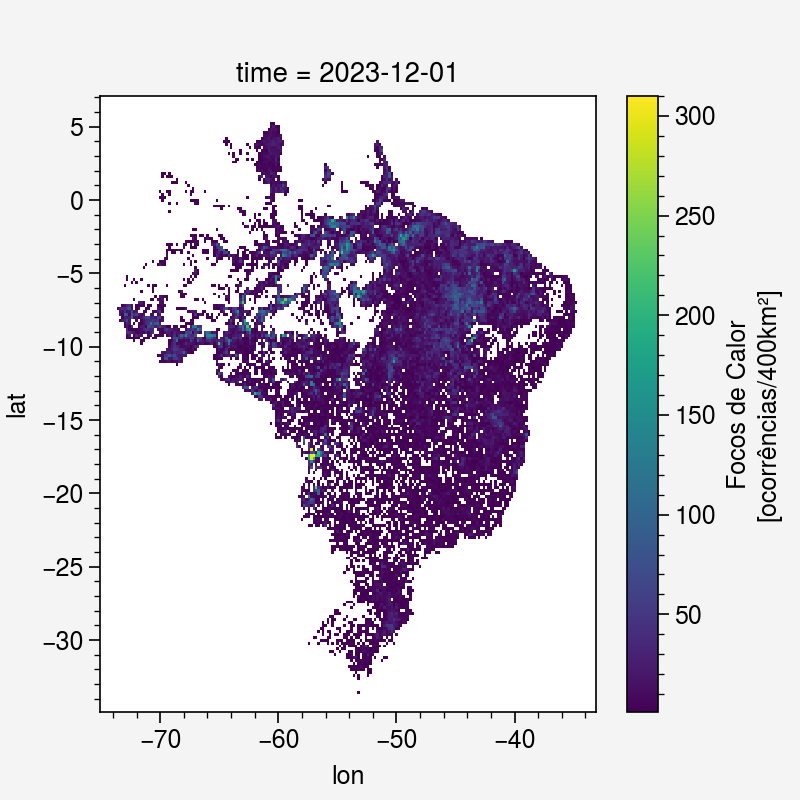

In [10]:
focos_por_ano['focos'][20,:,:].plot()

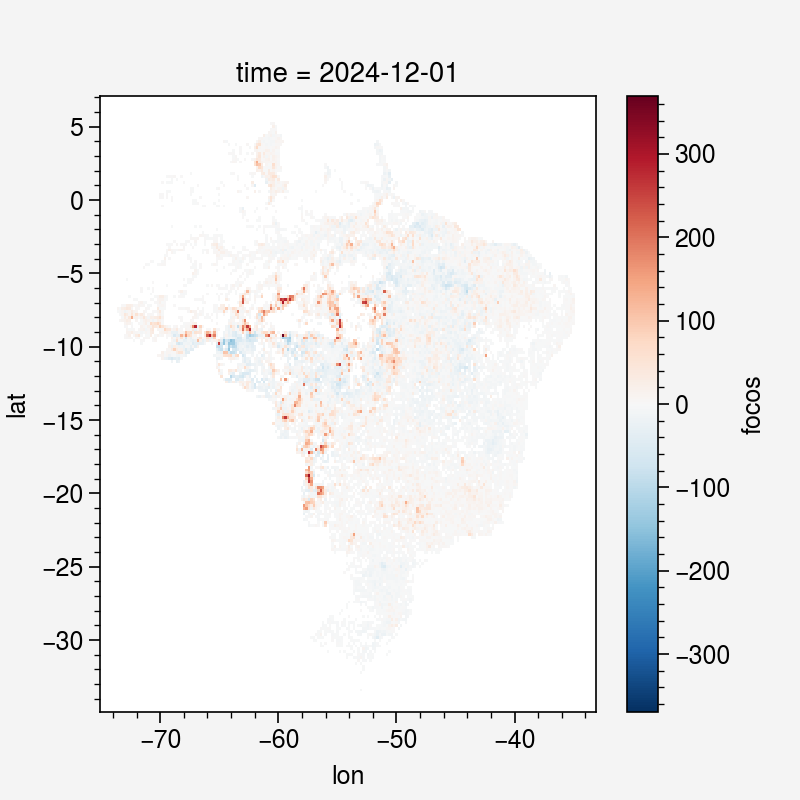

In [11]:
anomalia['focos'][:,:].plot()

# **6° Passo:** Figura

CPU times: user 9.1 s, sys: 134 ms, total: 9.24 s
Wall time: 13.7 s


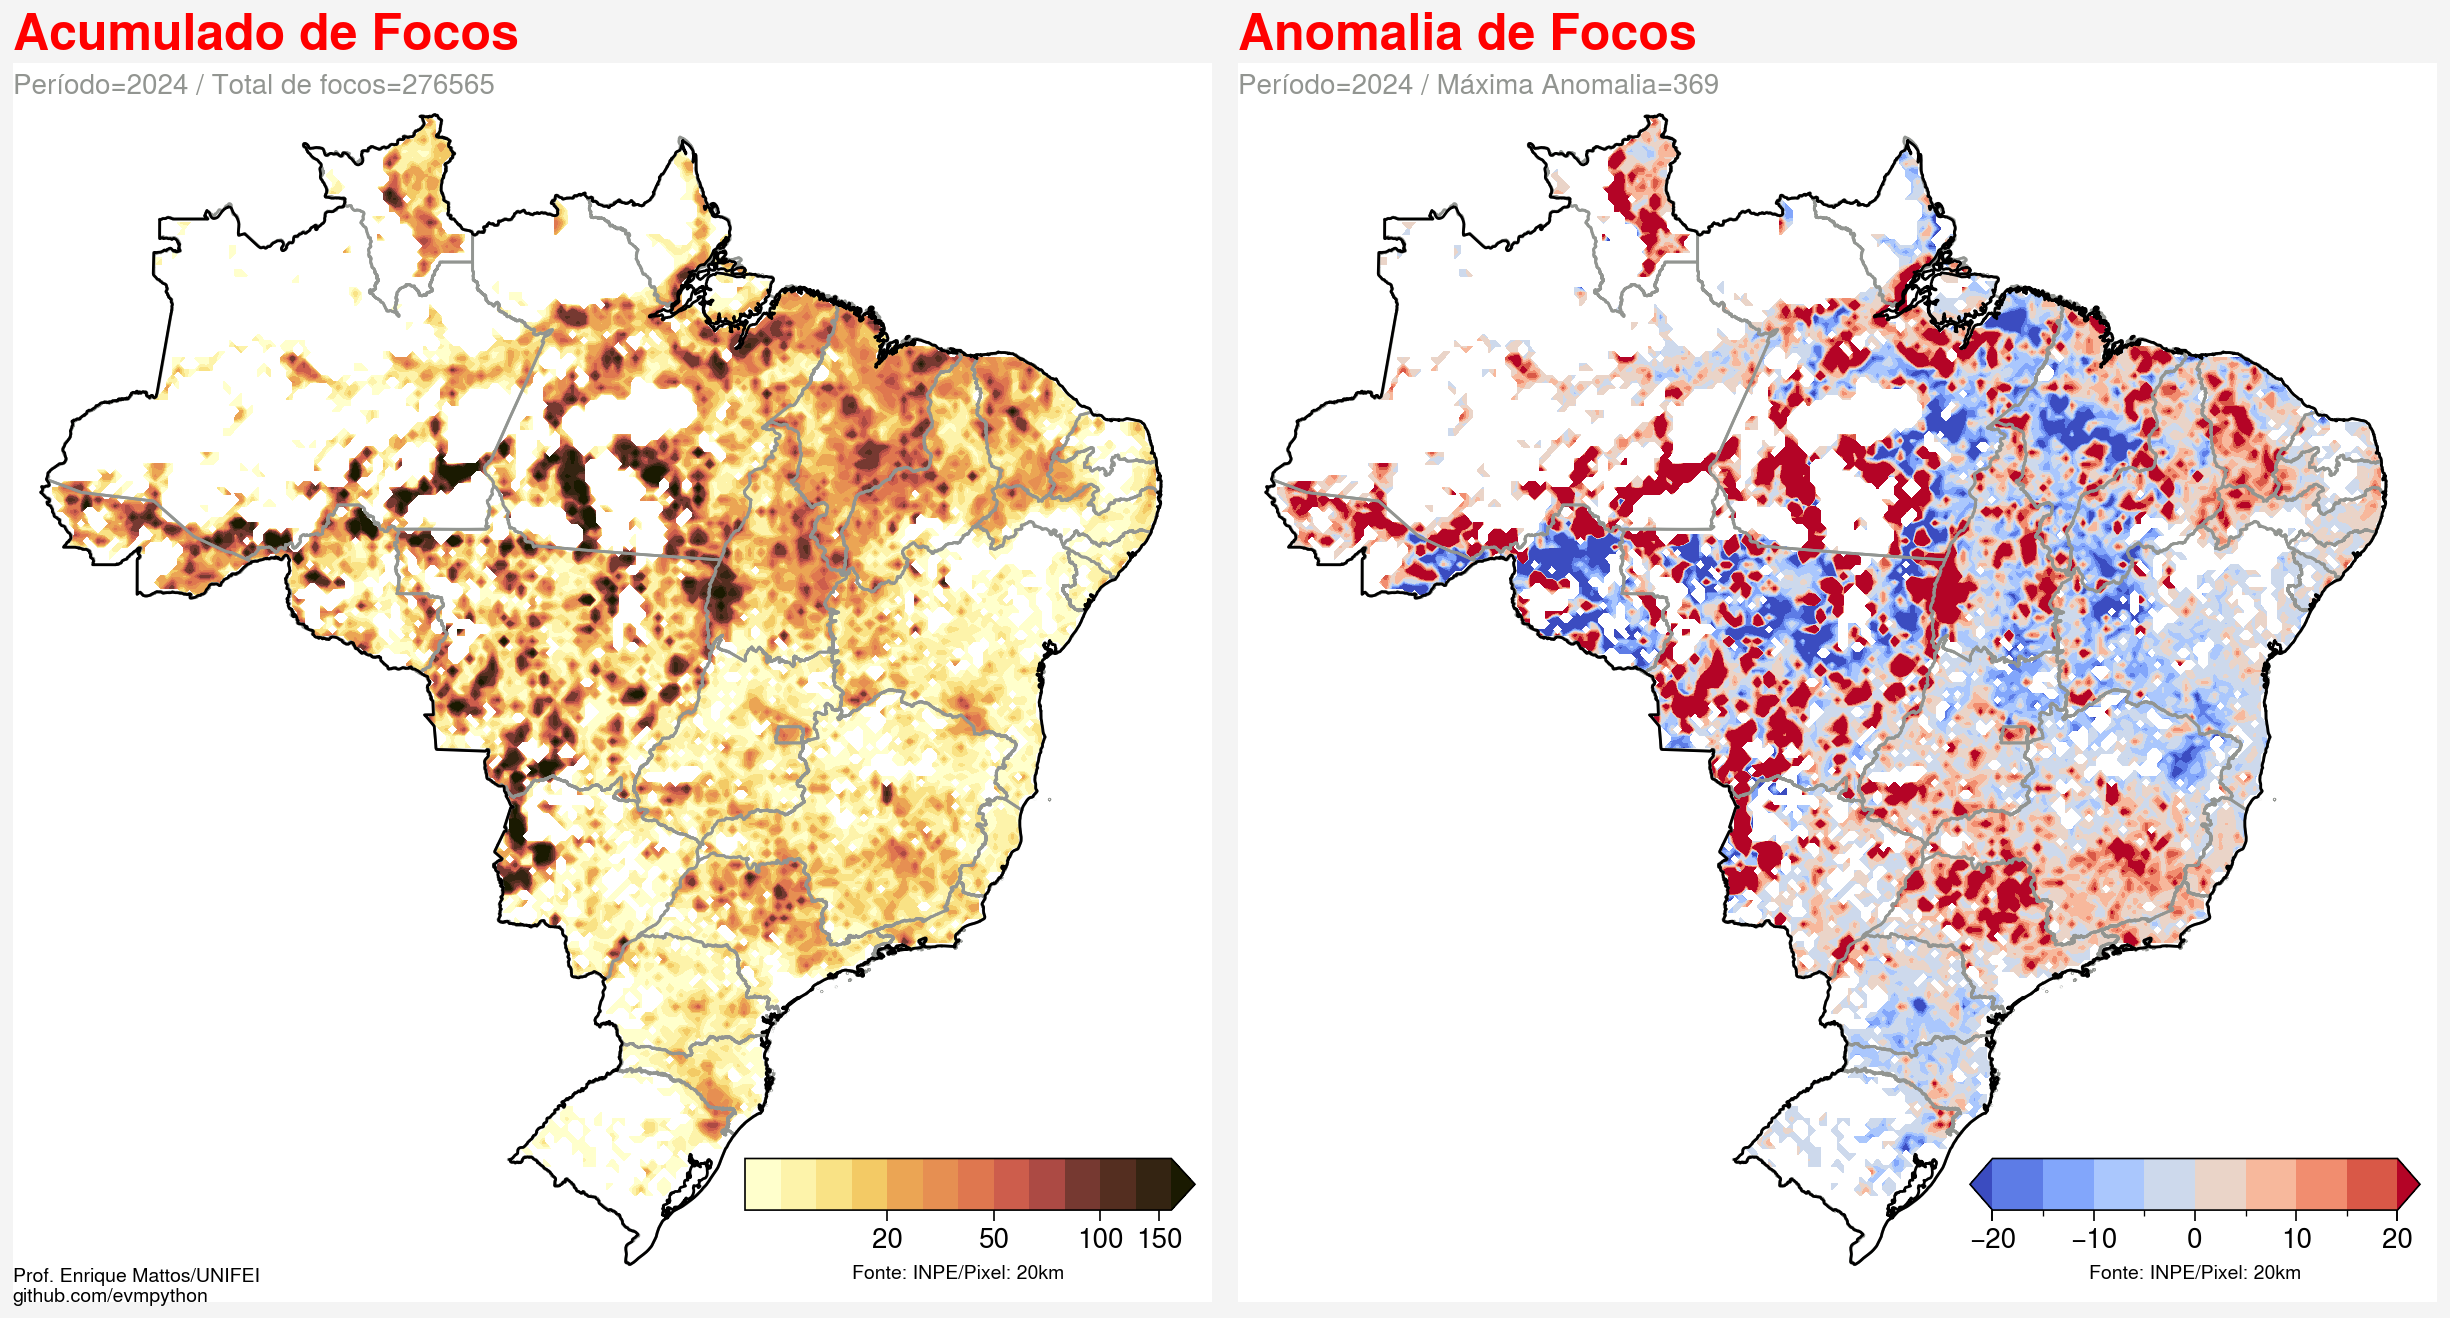

In [12]:
%%time
#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = uplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

#--------------------------------------------------------------#
#                            FIG-1
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(focos_por_ano['lon'],
                      focos_por_ano['lat'],
                      focos_por_ano['focos'].loc[f'{ano}-12-01'].salem.roi(shape=shapefile_brasil),
                      cmap='lajolla',
                      vmin=0, vmax=160,
                      levels=np.array([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 130, 160]),
                      extend='max',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: INPE/Pixel: 20km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': [20, 50, 100, 150],
                                   'ticklabels': ['20', '50', '100', '150']})

# título da figura
ax[0].format(title=f'Acumulado de Focos',
             titleloc='l',
             titleweight='bold',
             titlecolor='red')

# plota subtítulo
total = focos_por_ano['focos'].loc[f'{ano}-12-01'].salem.roi(shape=shapefile_brasil)
total = int(np.sum(total))
ax[0].text(lonmin, latmax-1.0, f'Período={ano} / Total de focos={total}', color='grey', fontsize=10)

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                            FIG-2
#--------------------------------------------------------------#
ax[1].contourf(anomalia['lon'],
               anomalia['lat'],
               anomalia['focos'][:,:],
               cmap='coolwarm',
               vmin=-20, vmax=20,
               levels=uplt.arange(-20, 20, 5),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: INPE/Pixel: 20km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 10})

# título da figura
ax[1].format(title=f'Anomalia de Focos',
             titleloc='l',
             titleweight='bold',
             titlecolor='red')

# plota subtítulo
total = anomalia['focos'][:,:]
total = int(np.max(total))
ax[1].text(lonmin, latmax-1.0, f'Período={ano} / Máxima Anomalia={total}', color='grey', fontsize=10)

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'03_acumulado_e_anomalia_focos_{ano}_BRASIL.png', dpi=300)